In [1]:
from __future__ import print_function
from __future__ import division
from PIL import Image, ImageDraw
import torchvision.models as models
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os, random
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0
using device: cuda
GeForce GTX 1650


In [4]:
#load FasterRCNN model using ResNet trained on COCO
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [5]:
#write super casses in json file
#keys are ','-separated class labels, values are super clases/ group names
super_COCO_classes = {
    'person': 'person',
    'bicycle,car,motorcycle,airplane,bus,train,truck,boat': 'modes of transport',
    'traffic light,fire hydrant,stop sign,parking meter,bench': 'street view',
    'bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe': 'animals',
    'frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket' :'sports',
    'banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake': 'food',
    'wine glass,cup,fork,knife,spoon,bowl': 'kitchen',
    'couch,potted plant,bed,dining table,toilet,sink,clock,vase': 'indoor',
    'tv,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,refrigerator,hair drier,': 'electronis',
    'book,scissors,teddy bear,toothbrush,tie,backpack,umbrella,handbag,suitcase,chair,bottle': 'misc'
}
with open('coco_labels_super.json', 'w') as fp:
    json.dump(super_COCO_classes, fp)

Number of classes  80
Number of super classes  10
0 ->  animals, person, 
1 ->  misc, 
2 ->  person, sports, 
3 ->  modes of transport, person, 
4 ->  animals, person, street view, 


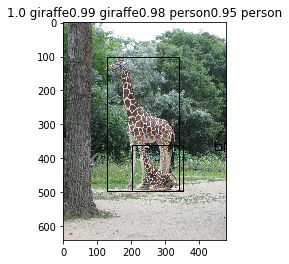

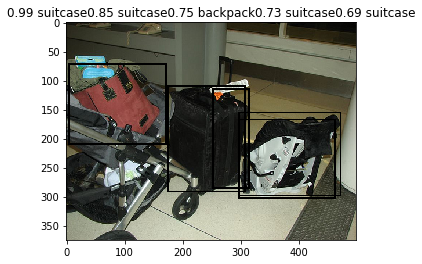

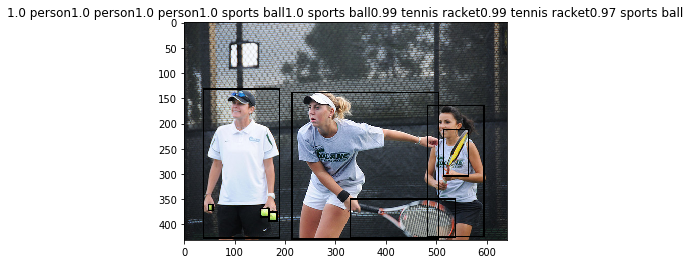

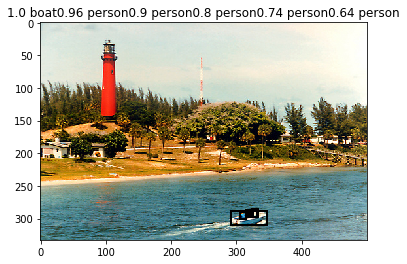

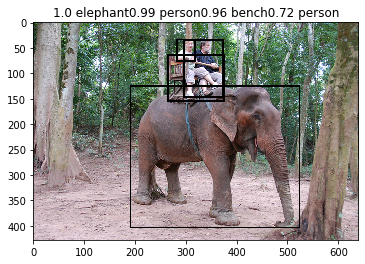

In [7]:
display_images = True
score_threshold = 0.6

# read COCO classes from file
def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    for line in labels:
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] #int(ids[1])
    return label_map
label_map = get_label_map('coco_labels.txt')
print("Number of classes ", len(label_map))

# read super classes from json file
with open('coco_labels_super.json', 'r') as fp:
    temp = json.load(fp)
print("Number of super classes ", len(temp))
super_COCO_classes ={}
#changing keys to ',' separated labels to single labels
for k in temp:
    class_labels = k.split(',')
    for label in class_labels:
        if label not in super_COCO_classes:
            super_COCO_classes[label] = temp[k]
        else:
            super_COCO_classes[label] += ', '+ temp[k]

#read images from file list
image_names = random.sample(os.listdir('../ssd.pytorch/data/coco/images/trainval35k'), 5)
x = []
images = []
for img in image_names:
    image = Image.open('../ssd.pytorch/data/coco/images/trainval35k/'+img)
    images.append(image)
    image_tensor = torchvision.transforms.functional.to_tensor(image)
    x.append(image_tensor)


#output super classes
output = model(x)
for i in range(len(output)):
    scores = output[i]['scores'].tolist()
    boxes = output[i]['boxes'].tolist()
    labels = output[i]['labels'].tolist()
    output_classes = ''
    
    img1 = images[i].copy()
    fig_title = ''
    for index, score in enumerate(scores):
        if score > score_threshold:
            label = label_map[labels[index]].strip() #remove leading and trailing spaces if any
            if label in super_COCO_classes and output_classes.find(super_COCO_classes[label]) == -1:
                output_classes +=  super_COCO_classes[label] + ", "
            if display_images:
                x1, y1, x2, y2 = boxes[index] 
                fig_title += str(round(scores[index],2))+" "+label
                draw = ImageDraw.Draw(img1)
                draw = draw.rectangle((x1, y1, x2, y2), outline ="black", width=3)
    print(i, "-> ", output_classes)
    if display_images:
        plt.figure()
        plt.imshow(img1)
        plt.title(fig_title)
    

In [3]:
# import torchvision.datasets as dset
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.Resize((500, 500)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)
import torchvision.transforms as transforms

#download COCO validation dataset
# http://images.cocodataset.org/zips/val2014.zip
#download annotations
# http://images.cocodataset.org/annotations/annotations_trainval2014.zip

cap = datasets.CocoDetection(root = '../ssd.pytorch/data/coco/images/trainval35k',
#                         annFile = 'ssd.pytorch/data/coco/annotations/instances_trainval35k.json',
                        annFile = '../ssd.pytorch/data/annotations/annotations/instances_val2014.json',
                        transform=get_transform())
#                         transform=transforms.ToTensor())
print(len(cap))

loading annotations into memory...
Done (t=10.55s)
creating index...
index created!
40504


In [ ]:
from nms import nms
from mean_average_precision import mean_average_precision
# collate_fn needed for batch
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader = {}
data_loader = torch.utils.data.DataLoader(cap,
                                          batch_size=16,
                                          shuffle=True,
                                          collate_fn=collate_fn)

# for data in data_loader:
perform_nms = False

# for iou_t, t in [[0.3, 0.7], [0.5, 0.5], [0.7, 0.3]]:
true_bbox = []
pred_bbox = []
count = 0
for (img, anno) in data_loader:
    x = torch.stack(img)
    output = model(x)

    for i in range(len(output)):
        output_classes = ''
        class_labels = ''
        scores = output[i]['scores'].tolist()
        boxes = output[i]['boxes'].tolist()
        labels = output[i]['labels'].tolist()
        nms_input = []
        for index, score in enumerate(scores):
            if perform_nms:
                nms_input.append([labels[index], score, x1, y1, x2, y2])
            else:
                if score > score_threshold:
                    nms_input.append([labels[index], score, x1, y1, x2, y2])
        
        if perform_nms:
            nms_output = nms(nms_input, iou_t, t, "corners")
        else:
            nms_output = nms_input
        for item in nms_output:
            label, prob, x1, y1, x2, y2 = item
            temp_list = [count]
            temp_list.extend(item)
            pred_bbox.append(temp_list)
            if prob > score_threshold:
                label_name = label_map[label].strip() #remove leading and trailing spaces if any
                if label_name in super_COCO_classes and output_classes.find(super_COCO_classes[label_name]) == -1:
                    output_classes +=  super_COCO_classes[label_name] + ", "
                class_labels += label_name +" "
        print(count, "-> ", output_classes)#, "\t ", class_labels)
        for item in anno[i]:
            x1, y1, x2, y2 = item['bbox']
            temp_list = [count]
            temp_list.extend([item['category_id'], 1.0, x1, y1, x2, y2])
            true_bbox.append(temp_list)
        count += 1
    if count>100:
        break

print(len(pred_bbox), len(true_bbox), count)
mAP = mean_average_precision(pred_bbox, true_bbox, 0.5, "corners", num_classes=80 )
print(iou_t, ", ", t, ": ",mAP.item())